# Gerchberg-Saxton (GS) Algorithm for Holocurtain

### [Link to the paper](https://imaging.cs.cmu.edu/holocurtains/#home)

![GS algorithm in holocurtain paper](imgs/GS_paper.jpg)

## GS Algorithm Implementation

In [1]:
import numpy as np
import numpy.fft as F
import cv2 as cv
import matplotlib.pyplot as plt
import PIL.Image as Image
import requests

In [2]:
# step1: Random Init for 2D binary image
def random_init(w: int, h: int) -> np.ndarray:
    return np.random.randint(0, 2, (w, h))

# plt.imshow(random_init(10, 10), cmap='gray')

In [3]:
def normalize_img(img: np.ndarray, mn: float = -1, mx: float = -1) -> np.ndarray:
    if mx == -1:
        mx = img.max()
    if mn == -1:
        mn = img.min()
    return (img - mn) / (mx - mn)

In [4]:
def resize_for_target(img: np.ndarray, DMD_resolution: tuple[int, int] = (1920, 1080)) -> np.ndarray:
    # resize target size to DMD_resolution
    return normalize_img(np.array(Image.fromarray(img).resize(DMD_resolution, Image.BILINEAR)))
    # return normalize_img(cv.resize(img, DMD_resolution, interpolation=cv.INTER_AREA))

In [5]:
def GS(target: np.ndarray, iter: int = 10, abr: np.ndarray = None) -> np.ndarray:
    h, w = target.shape
    # step1: Random Init for 2D binary image
    u = np.random.rand(h, w) >= 0.5
    u = u.astype(np.complex_)
    if abr is None:
        abr = np.ones_like(target)
    for _ in range(iter):
        # step2: Forward Propagation
        u = F.fft2(u * abr)
        u = F.fftshift(u)
        # step3: Amplitude Constraint
        u = np.sqrt(target) * np.exp(1j * np.angle(u))
        # step4: Backward Propagation
        u = F.ifftshift(u)
        u = F.ifft2(u)
        # step5: Binary Constraint
        u = np.real(u) >= 0
        u = u.astype(np.complex_)

    return u

## Define Evaluation Metrics
* **PSNR**: Peak Signal-to-Noise Ratio
* **SSIM**: Structural Similarity Index
* **NRMSE**: Normalized Root Mean Squared Error

In [6]:
def PSNR(target: np.ndarray, cmp: np.ndarray) -> float:
    mse = np.mean((target - cmp) ** 2)
    return 10 * np.log10(255 ** 2 / mse)

def SSIM(target: np.ndarray, cmp: np.ndarray) -> float:
    mu_x = np.mean(target)
    mu_y = np.mean(cmp)
    var_x = np.var(target)
    var_y = np.var(cmp)
    cov_xy = np.mean(target * cmp) - mu_x * mu_y
    c1 = (0.01 * 255) ** 2
    c2 = (0.03 * 255) ** 2
    return (2 * mu_x * mu_y + c1) * (2 * cov_xy + c2) / ((mu_x ** 2 + mu_y ** 2 + c1) * (var_x + var_y + c2))

def NRMSE(target: np.ndarray, cmp: np.ndarray) -> float:
    return np.sqrt(np.mean((target - cmp) ** 2)) / (target.max() - target.min())

In [7]:
def show_metrics(target: np.ndarray, cmp: np.ndarray) -> None:
    target = normalize_img(target) * 255
    cmp = normalize_img(cmp) * 255
    print(f'PSNR: {PSNR(target, cmp):.2f}dB')
    print(f'SSIM: {SSIM(target, cmp):.2f}')
    print(f'NRMSE: {NRMSE(target, cmp):.2f}')

def show_l1_diff(target: np.ndarray, cmp: np.ndarray) -> None:
    target = normalize_img(target) * 255
    cmp = normalize_img(cmp) * 255
    # maintain the range of 0~255
    diff = normalize_img(np.abs(target - cmp), 0, 255)
    plt.imshow(diff, cmap='gray')

In [22]:
# need to make sure target image is grayscale
# choose from 'target_pixelized.png', 'airforce_chart.png', 'simens_star.png'
target_img = 'simens_star.png'
target_out = 'GS_simens_star.bmp'
imgs_path = 'imgs'

img_path = f'{imgs_path}/{target_img}'

In [171]:
# img = np.array(Image.open(img_path))
# img = cv.cvtColor(img, cv.COLOR_RGBA2GRAY)
# cv.imwrite(f'{imgs_path}/gray_{target_img}', img)

## Testing on 2D Images

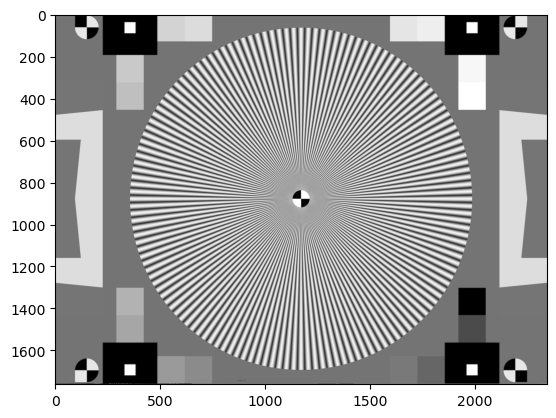

In [14]:
try:
    img = np.array(Image.open(img_path))
except FileNotFoundError:
    img = np.array(Image.open(requests.get(f'https://raw.githubusercontent.com/zhuyuezx/CSC494_holoprojector/main/Code/{img_path}', stream=True).raw))
img = img / 255.
plt.imshow(img, cmap='gray')

In [15]:
target = resize_for_target(img, (2716, 1600))
# target = img
# plt.imshow(target, cmap='gray')

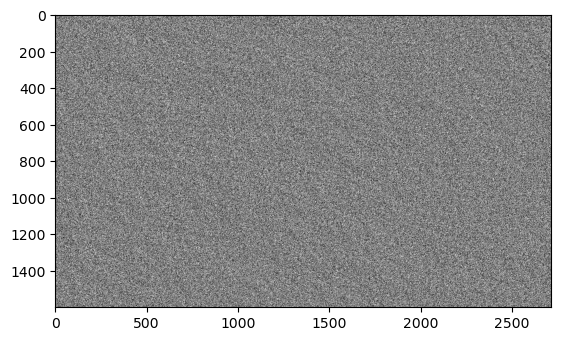

In [16]:
# Basic setting where there's no abrration
ret = GS(target, 10)
# see the final result for step 5
plt.imshow(np.abs(ret), cmap='gray')

In [23]:
cv.imwrite(f'{imgs_path}/{target_out}', (np.abs(ret) * 255).astype(np.uint8))

True

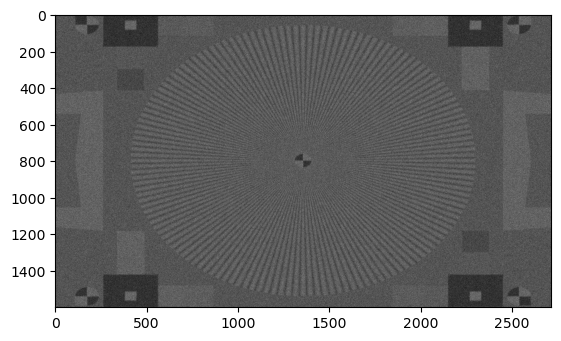

In [18]:
# See the final result for step 3
to_plot = np.abs(F.fft2(ret))
to_plot[0, 0] = 0
to_plot = normalize_img(np.abs(to_plot))
to_plot[0, 0] = to_plot.max()
to_plot = np.fft.fftshift(to_plot)
plt.imshow(np.abs(to_plot), cmap='gray')

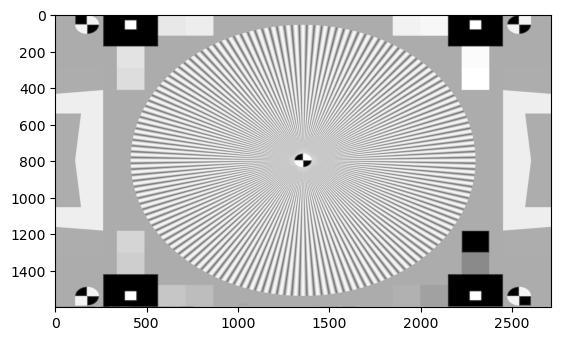

In [19]:
# See the final result for step 4
to_plot2 = F.fft2(ret)
to_plot2 = np.sqrt(target) * np.exp(1j * np.angle(to_plot2))
to_plot2 = normalize_img(np.abs(to_plot2))
plt.imshow(np.abs(to_plot2), cmap='gray')

In [20]:
show_metrics(target, to_plot2)

PSNR: 15.23dB
SSIM: 0.91
NRMSE: 0.17


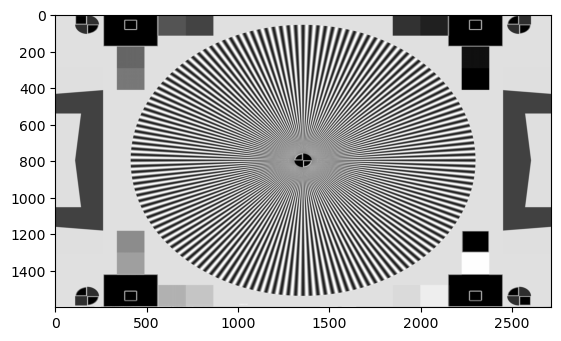

In [21]:
show_l1_diff(target, to_plot2)